In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error
import csv
from keras.regularizers import l2

2024-08-20 15:48:49.323997: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 15:48:49.329723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/modules/python/3.10.2/lib
2024-08-20 15:48:49.329741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Machine_learning_models:
    def __init__(self, input_dimension=None, output_dimension=None, estimators=None,random_state=None, layers=None, neuron_array=None):
        self.input = input_dimension
        self.output = output_dimension
        self.estimators= estimators
        self.random_state= random_state
        self.layers= layers
        self.neurons= neuron_array
        self.model = self.build_model()
        
    def build_model(self):
        if(len(self.neurons)==self.layers):
            model = Sequential()
            model.add(Dense(16, activation='relu', input_shape=(self.input,)))
            for layer in range(self.layers):
                model.add(Dense(self.neurons[layer], activation='relu'))
                
            model.add(Dense(self.output,))
            model.compile(optimizer='adam', 
            loss='mean_squared_error', 
            metrics=[MeanAbsoluteError()])
            return model
    
        else:
            print("number of layers and the neuron array length does not match , check it once!!")
    
    def scheduler(self, epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * 0.9
    
    def model_fit(self, train_x, train_y, epochs, batch_size, validation_split):
        lr_scheduler = LearningRateScheduler(self.scheduler)
        history = self.model.fit(train_x, train_y, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_split=validation_split, 
                                 callbacks=[lr_scheduler])
        loss= history.history['loss']
        val_loss= history.history['val_loss']
        epochs= range(1, len(loss)+1)
        plt.plot(epochs, loss, 'y', label= ' Training Loss' )
        plt.plot(epochs, val_loss, 'r', label= ' Validation Loss')
        plt.title('Traning and  Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        acc= history.history['mean_absolute_error']
        val_acc= history.history['val_mean_absolute_error']
        plt.plot(epochs, acc, 'y', label= ' Training MAE' )
        plt.plot(epochs, val_acc, 'r', label= ' Validation MAE')
        plt.title('Traning and  Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        
        
    def log_transformation(self, input_array):
        return np.log(input_array)

    def yeo_johnson_transform(self,data):
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data = pt.fit_transform(data.reshape(-1,1))
        return transformed_data
    
    # when the input data is the form of a gaussian apply standarization
    
    def standardization(self,input_array):
        mean= np.mean(input_array)
        st= np.std(input_array)
        x_trans= (input_array- mean)/st
        return x_trans , mean , st
    
    # when the data is not the form of a gaussian apply normalization
    
    def normalization(self,input_array):
        minimum= np.min(input_array) 
        delta= np.max(input_array)- np.min(input_array)
        x_trans= (input_array-minimum)/delta
        #print("min after normalizing the log quantity:", np.min(x_trans), "max after normalizing the log quantity:", np.max(x_trans))
        return x_trans.reshape(-1), delta, minimum
    
    
    def inverse_normalize(self,normalized_array, delta, minimum):
        X_retransformed= (normalized_array*delta)+ minimum
        #print("min after normalizing :", np.min( X_retransformed), "max after normalizing (should give max of log values):", np.max( X_retransformed))
        return  X_retransformed
    
    def inverse_standardization(self,standardized_array,mean, std):
        x_restandardized= (standardized_array*std)+mean
        return x_restandardized
        
    
    def mean_absolute_percentage_error(self, actual, test_x, delta , minimum, log= True):
        if(len(np.shape(actual))==2):
                if(log==False):
                    
                    predicted = self.model.predict(test_x)
                    actual_dim1 = actual[:, 0]
                    actual_dim2 = actual[:, 1]
                    predicted_dim1 = predicted[:, 0]
                    predicted_dim2 = predicted[:, 1]
                    
                    rescaled_pred1= self.inverse_normalize(predicted_dim1, delta[0], minimum[0])
                    rescaled_pred2= self.inverse_normalize(predicted_dim2, delta[1], minimum[1])
                    rescaled_actual1= self.inverse_normalize(actual_dim1, delta[0], minimum[0])
                    rescaled_actual2= self.inverse_normalize(actual_dim2, delta[1], minimum[1])
                    
                    mape_dim1 = np.mean(np.abs((actual_dim1 - predicted_dim1) / actual_dim1)) * 100
                    mape_dim2 = np.mean(np.abs((actual_dim2 - predicted_dim2) / actual_dim2)) * 100
                    mape = (mape_dim1 + mape_dim2) / 2
                    
                    rescaled_mape1 = np.mean(np.abs((rescaled_actual1 - rescaled_pred1) / rescaled_actual1)) * 100
                    rescaled_mape2 = np.mean(np.abs((rescaled_actual2 - rescaled_pred2) / rescaled_actual2)) * 100
                    
                    mape_rescaled= (rescaled_mape1+ rescaled_mape2)/2
                    print(f'MAPE combined scaled( only normalized data ): {mape}')
                    print(f'MAPE combined linear (rescaled to original): {mape_rescaled}')
                    
                    return [mape, mape_rescaled] , predicted
                    
                else:
                    
                    predicted = self.model.predict(test_x)
                    actual_dim1 = actual[:, 0]
                    actual_dim2 = actual[:, 1]
                    predicted_dim1 = predicted[:, 0]
                    predicted_dim2 = predicted[:, 1]
                    
                    rescaled_pred1= self.inverse_normalize(predicted_dim1, delta[0], minimum[0])
                    rescaled_pred2= self.inverse_normalize(predicted_dim2, delta[1], minimum[1])
                    rescaled_actual1= self.inverse_normalize(actual_dim1, delta[0], minimum[0])
                    rescaled_actual2= self.inverse_normalize(actual_dim2, delta[1], minimum[1])
                    
                    revserse_pred1 = np.exp(rescaled_pred1)
                    reverse_pred2= np.exp(rescaled_pred2)
                    reverse_actual1 = np.exp(rescaled_actual1)
                    revserse_actual2= np.exp(rescaled_actual2)
                    
                    
                    mape_dim1 = np.mean(np.abs((actual_dim1 - predicted_dim1) / actual_dim1)) * 100
                    mape_dim2 = np.mean(np.abs((actual_dim2 - predicted_dim2) / actual_dim2)) * 100
                    mape = (mape_dim1 + mape_dim2) / 2
                    
                    rescaled_mape1 = np.mean(np.abs((reverse_actual1 - reverse_pred1) / reverse_actual1)) * 100
                    rescaled_mape2 = np.mean(np.abs((reverse_actual2 - reverse_pred2) / reverse_actual2)) * 100
                    
                    mape_reverse= (rescaled_mape1+ rescaled_mape2)/2
                    print(f'MAPE combined scaled( data log scaled and normalized ): {mape}')
                    print(f'MAPE combined linear: {mape_rescaled}')
                    
                    return [mape, mape_rescaled] , predicted
                    
                    
                
                        

        

        else:        
            if(log==True):
                y_pred = self.model.predict(test_x).reshape(-1)
                mape= np.mean(np.abs((actual - y_pred) / actual)) * 100
                print(f'MAPE scaled( data both log scaled and normalized ): {mape}')
                
                rescaled_pred= self.inverse_normalize(y_pred, delta, minimum)
                reverse_pred= np.exp(rescaled_pred)
                rescaled_actual= self.inverse_normalize(actual, delta, minimum)
                reverse_actual= np.exp(rescaled_actual)
                rescaled_mape=  np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                
                print(f'MAPE linear : {rescaled_mape}')
                return  [mape,rescaled_mape], y_pred.reshape(-1)
            
            else:
                y_pred = self.model.predict(test_x).reshape(-1)
                mape= np.mean(np.abs((actual - y_pred) / actual)) * 100
                print(f'MAPE scaled( data only normalized): {mape}')
    
                rescaled_pred= self.inverse_normalize(y_pred, delta, minimum)
                rescaled_actual= self.inverse_normalize(actual, delta, minimum)
                rescaled_mape=  np.mean(np.abs((rescaled_actual - rescaled_pred) / rescaled_actual)) * 100
                
                print(f'MAPE linear : {rescaled_mape}')
                return  [mape,rescaled_mape], y_pred.reshape(-1)

            
    def prediction_vs_actual(self, y_pred, test_y, delta, minimum, x_axis_label, y_axis_label, log=True, rescale=True, scaling=None):
        if (len(np.shape(test_y)) == 1):
            if rescale:
                if log:
                     rescaled_actual = self.inverse_normalize(test_y, delta, minimum)
                     reverse_actual = np.exp(rescaled_actual)
                     rescaled_pred = self.inverse_normalize(y_pred, delta, minimum)
                     reverse_pred = np.exp(rescaled_pred)
                     mape = np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                     plt.figure(figsize=(10, 6))
                     plt.scatter(reverse_actual, reverse_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                     plt.plot([reverse_actual.min(), reverse_actual.max()], [reverse_actual.min(), reverse_actual.max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                     plt.xlabel(x_axis_label)
                     plt.ylabel(y_axis_label)
                     plt.title('Predicted vs Actual plot')
                     plt.xscale("log")
                     plt.yscale("log")
                     plt.legend()
                     plt.grid(True)
                     plt.show()
                else:
                     rescaled_actual = self.inverse_normalize(test_y, delta, minimum)
                     rescaled_pred = self.inverse_normalize(y_pred, delta, minimum)
                     print("this one was executed")
                     plt.figure(figsize=(10, 6))
                     plt.scatter(rescaled_actual, rescaled_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                     plt.plot([rescaled_actual.min(), rescaled_actual.max()], [rescaled_actual.min(), rescaled_actual.max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                     plt.xlabel(x_axis_label)
                     plt.ylabel(y_axis_label)
                     plt.title('Predicted vs Actual plot')
                     plt.legend()
                     plt.grid(True)
                     plt.show()
            else:
                plt.figure(figsize=(10, 6))
                plt.scatter(test_y, y_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='red', linestyle='--', 
                         linewidth=2, label='Ideal')
                plt.xlabel(x_axis_label)
                plt.ylabel(y_axis_label)
                plt.title('Predicted vs Actual plot')
                plt.legend()
                plt.grid(True)
                plt.show()
        else:
            if rescale:
                if log:
                    for i in range(2):
                        rescaled_actual = self.inverse_normalize(test_y[:, i], delta[i], minimum[i])
                        reverse_actual = np.exp(rescaled_actual)
                        rescaled_pred = self.inverse_normalize(y_pred[:, i], delta[i], minimum[i])
                        reverse_pred = np.exp(rescaled_pred)
                        mape = np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                        plt.figure(figsize=(10, 6))
                        plt.scatter(reverse_actual, reverse_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                        plt.plot([reverse_actual.min(), reverse_actual.max()], [reverse_actual.min(), reverse_actual.max()], 
                                 color='red', linestyle='--', linewidth=2, label='Ideal')
                        plt.xlabel(x_axis_label[i])
                        plt.ylabel(y_axis_label[i])
                        plt.title('Predicted vs Actual plot')
                        plt.xscale("log")
                        plt.yscale("log")
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                else:
                    for i in range(2):
                        rescaled_actual = self.inverse_normalize(test_y[:, i], delta[i], minimum[i])
                        rescaled_pred = self.inverse_normalize(y_pred[:, i], delta[i], minimum[i])
                        mape = np.mean(np.abs((rescaled_actual - rescaled_pred) / rescaled_actual)) * 100
                        plt.figure(figsize=(10, 6))
                        plt.scatter(rescaled_actual, rescaled_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                        plt.plot([rescaled_actual.min(), rescaled_actual.max()], [rescaled_actual.min(), rescaled_actual.max()], 
                                 color='red', linestyle='--', linewidth=2, label='Ideal')
                        plt.xlabel(x_axis_label[i])
                        plt.ylabel(y_axis_label[i])
                        plt.title('Predicted vs Actual plot')
                        plt.legend()
                        plt.grid(True)
                        plt.show()
            else:
                for i in range(2):
                    mape = np.mean(np.abs((test_y[:, i] - y_pred[:, i]) / test_y[:, i])) * 100
                    plt.figure(figsize=(10, 6))
                    plt.scatter(test_y[:, i], y_pred[:, i], color='blue', alpha=0.2, label='Predicted vs Actual')
                    plt.plot([test_y[:, i].min(), test_y[:, i].max()], [test_y[:, i].min(), test_y[:, i].max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                    plt.xlabel(x_axis_label[i])
                    plt.ylabel(y_axis_label[i])
                    plt.title('Predicted vs Actual plot')
                    plt.legend()
                    plt.grid(True)
                    plt.show()


    def prediction(self, input_data, log=False, Norm= False, delta=None, minima= None):
        '''Takes input data and give the model prediction out
        use it for observational data'''
        if(log==False and Norm==False):
            output = self.model.predict(input_data)
            return output
        
        if(log== True and Norm==True):
            output= self.model.predict(input_data).reshape(-1)
            rescale= self.inverse_normalize(output, delta, minima)
            reverse= np.exp(rescale)
            return reverse
    
    def Random_forest(self, test_y, test_x):
        random_forest= RandomForestRegressor(n_estimators=self.estimators, random_state=self.random_state)
        random_forest.fit(train_x, train_y)
        y_pred_rf= random_forest.predict(test_x)
        mse_rf= mean_squared_error(test_y, y_pred_rf)
        mae_rf= mean_absolute_error(test_y, y_pred_rf)
        mape= np.mean(np.abs((test_y - y_pred_rf) / test_y)) * 100
        print(f'MAPE: {mape}')
        return y_pred_rf
    
    def Regression_tree(self, test_y, test_x):
        tree= DecisionTreeRegressor()
        tree.fit(train_x, train_y)
        y_pred_dt= tree.predict(test_x)
        mape= np.mean(np.abs((test_y - y_pred_dt) / test_y)) * 100
        print(f'MAPE: {mape}')
        return y_pred_dt


    def value_table(self, file_name, test_y, output, output_delta, output_minima, test_array_header, output_array_header):
            '''This function takes in the test values of the data and gives out a csv file that has the true value and the 
              corresponding predicted value for that data point
            '''
            test_renormalized= np.exp(self.inverse_normalize(test_y, output_delta, output_minima))
            prediction_renormalized= np.exp(self.inverse_normalize(output, output_delta, output_minima))
            data = {
            test_array_header: test_renormalized,
            output_array_header: prediction_renormalized
            }
            df = pd.DataFrame(data)
            
            with open(file_name, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([test_array_header, output_array_header])
                for i in range(len(df)):
                    writer.writerow([df.iloc[i, 0], df.iloc[i, 1]])
            
                    

                        
        

In [3]:
csv_file = '/home/ajain/cloudphinder/data_all_particles_added_dv_3d_cutoff>=100'

df = pd.read_csv(csv_file, sep='\t')
data_array = df.to_numpy()

mean= data_array[:, 5].astype(float).reshape(-1)
variance = data_array[:, 6].astype(float).reshape(-1)
density_2d = data_array[:,0].astype(float).reshape(-1)
dispersion_velocity= data_array[: ,2].astype(float).reshape(-1)
galacto_centric_distance=  data_array[:, 3].astype(float).reshape(-1)
projected_distance= data_array[:,4].astype(float).reshape(-1)
density_3d= data_array[:,1].astype(float).reshape(-1)
dispersion_3d= data_array[:,7].astype(float).reshape(-1) 

print(np.max(dispersion_3d))
print(np.min(dispersion_3d))

87.05248766817022
3.367153565204359


In [4]:
mean_model=  Machine_learning_models(input_dimension=3, output_dimension=1, estimators=400, random_state=400,layers=6, neuron_array=[32,64,64,64,64,32])

log_projection=mean_model.log_transformation(projected_distance)
log_density= mean_model.log_transformation(density_2d)
log_density3d= mean_model.log_transformation(density_3d)


transformed_dispersion, dipersion_delta, dispersion_min =  mean_model.normalization(dispersion_velocity)
transformed_distance, distance_delta, distance_min =  mean_model.normalization(galacto_centric_distance)
transformed_projection, projection_delta, projection_min =  mean_model.normalization(log_projection)
transformed_density, density_delta, density_min =  mean_model.normalization(log_density)
transformed_density3d, density_delta3d, density_min3d =  mean_model.normalization(log_density3d)
transformed_mean, mean_delta, mean_min = mean_model.normalization(mean)
transformed_variance, variance_delta, variance_min = mean_model.normalization(variance)

transformed_dispersion_3d, dispersion_3d_delta, dispersion_3d_min =  mean_model.normalization(dispersion_3d)

2024-08-20 15:48:55.723095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/modules/python/3.10.2/lib
2024-08-20 15:48:55.723126: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-20 15:48:55.723154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (homard): /proc/driver/nvidia/version does not exist
2024-08-20 15:48:55.723718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
mean_input= np.stack((transformed_density, transformed_dispersion, transformed_distance), axis=1)
mean_output= transformed_mean
train_x, test_x, train_y, test_y = train_test_split(mean_input, mean_output, random_state=0, train_size=0.90)


Epoch 1/30
317/317 [==============================] - 1s 3ms/step - loss: 0.0513 - mean_absolute_error: 0.1443 - val_loss: 0.0160 - val_mean_absolute_error: 0.1002 - lr: 0.0010
Epoch 2/30
317/317 [==============================] - 1s 2ms/step - loss: 0.0147 - mean_absolute_error: 0.0911 - val_loss: 0.0150 - val_mean_absolute_error: 0.0913 - lr: 0.0010
Epoch 3/30
317/317 [==============================] - 1s 2ms/step - loss: 0.0145 - mean_absolute_error: 0.0902 - val_loss: 0.0152 - val_mean_absolute_error: 0.0964 - lr: 0.0010
Epoch 4/30
317/317 [==============================] - 1s 2ms/step - loss: 0.0143 - mean_absolute_error: 0.0897 - val_loss: 0.0159 - val_mean_absolute_error: 0.0876 - lr: 0.0010
Epoch 5/30
317/317 [==============================] - 1s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0899 - val_loss: 0.0149 - val_mean_absolute_error: 0.0953 - lr: 0.0010
Epoch 6/30
317/317 [==============================] - 1s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0899 - va

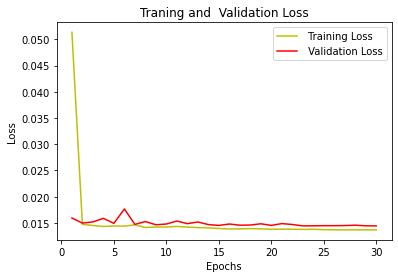

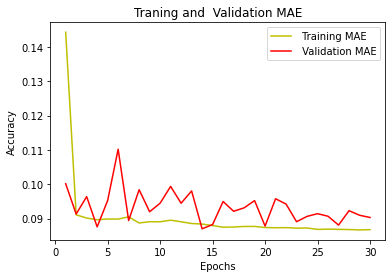

25/25 [==============================] - 0s 1ms/step
MAPE scaled( data only normalized): 12.030369312811914
MAPE linear : 60.18199326738682


In [6]:
history_model = mean_model.model_fit(train_x, train_y, epochs=30, batch_size=20, validation_split=0.1)
mape, y_pred= mean_model.mean_absolute_percentage_error(test_y, test_x, mean_delta, mean_min , log=False)


this one was executed


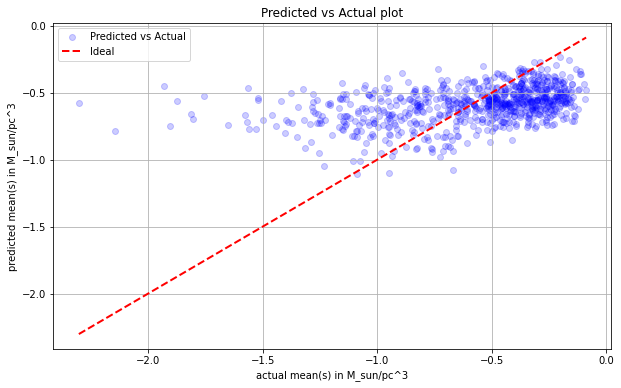

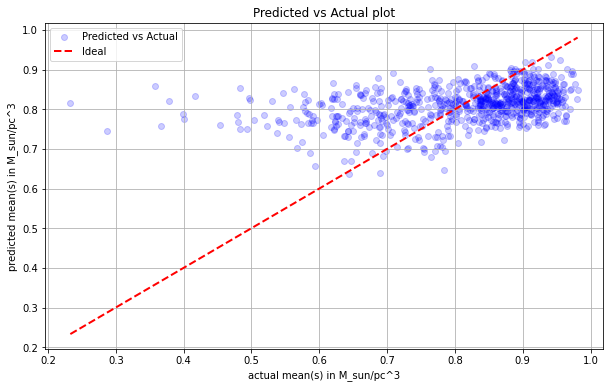

In [9]:
mean_model.prediction_vs_actual(y_pred, test_y, mean_delta, mean_min , "actual mean(s) in M_sun/pc^3", "predicted mean(s) in M_sun/pc^3", log=False)
mean_model.prediction_vs_actual(y_pred, test_y, mean_delta, mean_min, "actual mean(s) in M_sun/pc^3", "predicted mean(s) in M_sun/pc^3", rescale= False)


In [10]:
observational_data= '/home/ajain/cloudphinder/observation_data'
df = pd.read_csv(observational_data, sep='\t')
observation_array = df.to_numpy()

observation_density2d= observation_array[: ,2].astype(float).reshape(-1)
observation_GCD= observation_array[:, 1].astype(float).reshape(-1)
observation_SIGV = observation_array[:,0].astype(float).reshape(-1)

log_density2d= mean_model.log_transformation(observation_density2d)

transformed_density2d, density2d_delta, density2d_min = mean_model.normalization(log_density2d)
transformed_GCD, GCD_delta, GCD_min = mean_model.normalization(observation_GCD)
transformed_SIGV, SIGV_delta, SIGV_min = mean_model.normalization(observation_SIGV)

observational_input= np.column_stack((transformed_density2d, transformed_SIGV, transformed_GCD))


print(observational_input)


[[0.312215   0.27754656 0.2762437 ]
 [0.20545637 0.26332758 0.43861213]
 [0.26285127 0.26052963 0.30371565]
 ...
 [0.47557045 0.0627906  0.69711918]
 [0.30113436 0.30843386 0.06743637]
 [0.44509577 0.24207402 0.06131271]]


161/161 [==============================] - 0s 935us/step


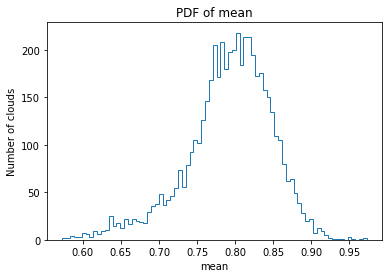

0.7917783
0.003179651


In [11]:
observation_result= mean_model.prediction(observational_input, log= False, Norm= False, delta= mean_delta, minima= mean_min)

mi= np.min(observation_result)
ma= np.max(observation_result)

new_bins= np.linspace(mi, ma , 80)

plt.hist(observation_result,bins=new_bins, density=False, histtype='step')
plt.title("PDF of mean")
plt.xlabel("mean")
plt.ylabel("Number of clouds")
plt.show()

print(np.mean(observation_result))
print(np.var(observation_result))



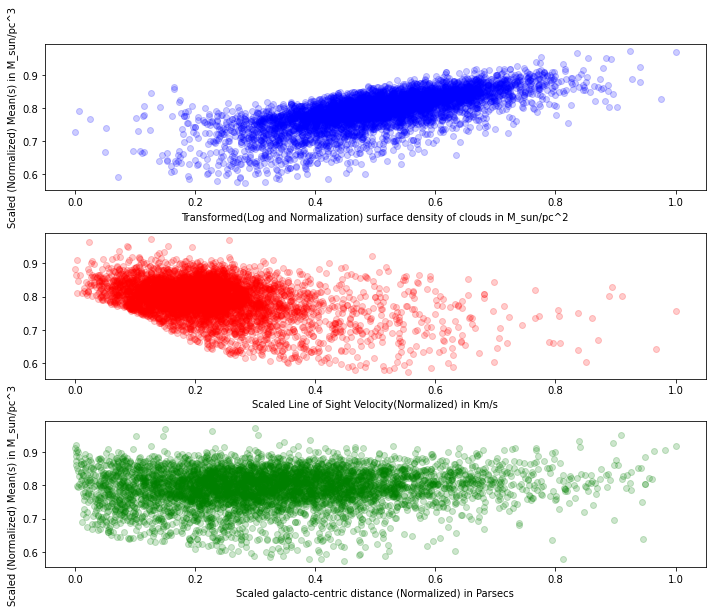

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# First scatter plot
axs[0].scatter(transformed_density2d, observation_result, color='b', alpha= 0.2)
#axs[0].set_title('Scatter Plot 1 de vs density_3d(y axis)')
#axs[0, 0].set_yscale('log
axs[0].set_xlabel("Transformed(Log and Normalization) surface density of clouds in M_sun/pc^2")
axs[0].set_ylabel("Scaled (Normalized) Mean(s) in M_sun/pc^3")
# Second scatter plot
axs[1].scatter(transformed_SIGV, observation_result, color='r', alpha=0.2)
#axs[1].set_title('Scatter Plot 2 dispersion velocity( x axis) vs density_3d(y axis)')
#axs[0, 1].set_yscale('log')
axs[1].set_xlabel("Scaled Line of Sight Velocity(Normalized) in Km/s")
axs[0].set_ylabel("Scaled (Normalized) Mean(s) in M_sun/pc^3")

# Third scatter plot
axs[2].scatter(transformed_GCD, observation_result, color='g', alpha=0.2)
#axs[2].set_title('Scatter Plot 3 galacto-centeric-distance(x axis) vs denisty_3d (y axis )')
#axs[1, 0].set_yscale('log')
axs[2].set_xlabel("Scaled galacto-centric distance (Normalized) in Parsecs")
axs[2].set_ylabel("Scaled (Normalized) Mean(s) in M_sun/pc^3")


# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig("scatter_plot_mean_model")
# Show the plot
plt.show()